In [65]:
import Pkg
packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
    "Accessors",
]

Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [66]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 
using Accessors

In [67]:
# 1. Physics: Nonlinear 2-DOF Oscillator
function two_mass_nonlinear!(du, u, p, t)
    x1, v1, x2, v2 = u[1], u[2], u[3], u[4]
    
    # --- Element 1 (Wall to Mass 1) ---
    fs1_lin = p.k1 * x1
    fd1_lin = p.c1 * v1
    fs1_non = p.alpha1 * (x1^3)
    fd1_non = p.gamma1 * (v1^3) # Nonlinear Damping 1
    
    F1_total = -(fs1_lin + fs1_non + fd1_lin + fd1_non)
    
    # --- Element 2 (Mass 1 to Mass 2) ---
    dx = x2 - x1
    dv = v2 - v1
    
    fs2_lin = p.k2 * dx
    fd2_lin = p.c2 * dv
    fs2_non = p.alpha2 * (dx^3)
    fd2_non = p.gamma2 * (dv^3) # Nonlinear Damping 2
    
    F2_total = fs2_lin + fs2_non + fd2_lin + fd2_non
    
    # --- Driving Force (on Mass 2) ---
    F_drive = p.F * cos(p.omega * t)

    # --- Equations of Motion ---
    du[1] = v1
    du[2] = (F1_total + F2_total) / p.m1
    du[3] = v2
    du[4] = (-F2_total + F_drive) / p.m2
end

# 2. Base Parameters
# Note: alpha (stiffness) is set to 0.5 to create a slight "tilt" 
# so the damping effect is more obvious and interesting.
par_base = (
    m1 = 1.0, m2 = 1.0, 
    k1 = 1.0, k2 = 1.0, 
    c1 = 0.1, c2 = 0.1, 
    alpha1 = 0, alpha2 = 0,  # Cubic Stiffness
    gamma1 = 0.0, gamma2 = 0.0,  # Cubic Damping (Will vary)
    F = 0.5, omega = 0.1
)

(m1 = 1.0, m2 = 1.0, k1 = 1.0, k2 = 1.0, c1 = 0.1, c2 = 0.1, alpha1 = 0, alpha2 = 0, gamma1 = 0.0, gamma2 = 0.0, F = 0.5, omega = 0.1)

In [68]:
# 3. Poincare Map
function poincare_map_2dof(u, p)
    omega = (p isa Real) ? p : p.omega
    T = 2π / omega
    
    # Check for T=Infinity or NaN issues at omega=0
    if T > 1000.0; T = 1000.0; end

    prob = ODEProblem(two_mass_nonlinear!, u, (0.0, T), p)
    sol = solve(prob, Rodas4(), reltol=1e-9, abstol=1e-9, save_everystep=false)
    return sol[end] - u
end

poincare_map_2dof (generic function with 1 method)

In [69]:
# 4. Continuation Options
opts = ContinuationPar(
    p_min = 0.1, 
    p_max = 3.0,       
    ds = 0.01,
    dsmax = 0.05,
    max_steps = 4000, 
    detect_bifurcation = 0, # Disable bifurcation detection for smoother plotting
    newton_options = NewtonPar(tol = 1e-8, max_iterations = 20)
)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.05
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 0.1
  p_max: Float64 3.0
  max_steps: Int64 4000
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 0
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [70]:
# 5. Helper Function to Run Scenarios
function run_damping_scenario(gamma_val, label_str, color_sym)
    println("Running analysis for gamma = $gamma_val ...")
    
    # Update the Gamma parameters in the tuple
    par_current = setproperties(par_base, gamma1 = gamma_val, gamma2 = gamma_val)
    
    # Initial guess
    u0 = [0.0, 0.0, 0.0, 0.0]

    prob = BifurcationProblem(poincare_map_2dof, u0, par_current, (@optic _.omega);
        record_from_solution = (x, p; k...) -> begin
            current_omega = (p isa Real) ? p : p.omega
            
            # CRITICAL: Reconstruct full parameters using the CURRENT gamma
            p_full = setproperties(par_current, omega = Float64(current_omega))
            
            T = 2π / p_full.omega
            prob_rec = ODEProblem(two_mass_nonlinear!, x, (0.0, T), p_full)
            sol_rec = solve(prob_rec, Rodas4(), reltol=1e-8, abstol=1e-8)
            
            # Return Amplitude of Mass 2
            return maximum(abs.(sol_rec[3, :]))
        end
    )
    
    branch = continuation(prob, PALC(), opts)
    return branch
end

run_damping_scenario (generic function with 1 method)

In [71]:
# 6. Run the Three Scenarios
# Case 1: No Nonlinear Damping
branch_none = run_damping_scenario(0.0, "No NL Damping", :green)

# Case 2: Medium Nonlinear Damping
branch_med  = run_damping_scenario(0.1, "Medium NL Damping", :blue)

# Case 3: High Nonlinear Damping
branch_high = run_damping_scenario(0.5, "High NL Damping", :red)

Running analysis for gamma = 0.0 ...
Running analysis for gamma = 0.1 ...
Running analysis for gamma = 0.5 ...


 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 105
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.1, ends at 3.0
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +3.00000000,                                                                     step = 104


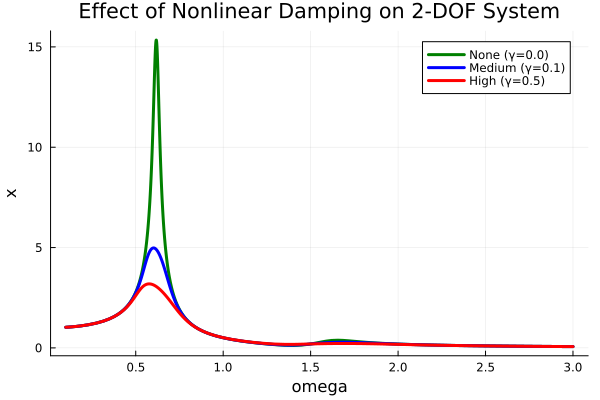

In [72]:
# 7. Plotting - Overlay all three
p = plot(branch_none, 
    title = "Effect of Nonlinear Damping on 2-DOF System",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Amplitude (Mass 2)",
    lw = 3, color = :green, label = "None (γ=0.0)",
    legend = :topright,
    grid = true
)

plot!(p, branch_med, lw = 3, color = :blue, label = "Medium (γ=0.1)")
plot!(p, branch_high, lw = 3, color = :red, label = "High (γ=0.5)")

display(p)